In [4]:
%cd /media/nicola/Data/Workspace/OSCAR/Oscar
%pwd

/media/nicola/Data/Workspace/OSCAR/Oscar


'/media/nicola/Data/Workspace/OSCAR/Oscar'

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json

%matplotlib inline

In [6]:
def prepare_inputs(experiments_file):
    with open(experiments_file, 'rb') as f:
        experiments = pickle.load(f)

    data = pd.DataFrame(experiments)

    # filter out high thresholds
    data = data[data['thresh'] <= 100]

    # compute mean per query
    data = data.groupby(['thresh'], as_index=False).mean()
    data
    data_npy = data.to_numpy()

    thresh, nz_elems, recall = data_npy[:, 0], data_npy[:, 2], data_npy[:, 3]
    return thresh, nz_elems, recall

In [7]:
# values is a dict of [series_name: (thresh, nz_elems, recall)]

def plot(values, figsize=(10,5), legend_loc='lower right', xlabel='SQ threshold', show_annotations=[True, False]): # values is a dict: key: "name", value: list of tuples
    plt.figure(figsize=figsize)
    marker = ['#133248', '#7a972c', '#800000', '#f09d06']
    for i, (name, p) in enumerate(values.items()):
        # plt.ylim(50, 85)
        plt.xticks(p[0])
        plt.xscale('log')
        plt.xlabel(xlabel)
        plt.ylabel("Recall@500")
        plt.plot(p[0], p[2], 's-', color=marker[i], markersize=5, label=name)
        if show_annotations[i]:
            for x, y, nz_elem in zip(p[0], p[2], p[1]):
                plt.annotate(str(int(nz_elem)), (x, y), xytext=(-25, 10),  # 3 points vertical offset
                        textcoords="offset points",bbox=dict(boxstyle="square,pad=0.2", fc="cyan", ec="b", lw=1))
    plt.grid(which="both")
    plt.legend(loc=legend_loc, prop={'size': 9})
    # plt.legend()

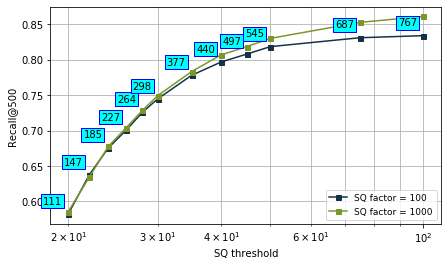

In [28]:
experiments_file_f100 = os.path.join('vbs', 'experiments', 'experiments_factor100.pkl')
data_f100 = prepare_inputs(experiments_file_f100)
experiments_file_f1000 = os.path.join('vbs', 'experiments', 'experiments_factor1000.pkl')
data_f1000 = prepare_inputs(experiments_file_f1000)

data = {'SQ factor = 100': data_f100, 'SQ factor = 1000': data_f1000}
plot(data, figsize=(7,4))
plt.savefig('vbs/VBS_recall_vs_threshold.pdf')

In [12]:
# VBS 2019 GT EVALUATION

def plot_ranks_vs_threshold(evaluation_file):
    with open(evaluation_file, 'r') as f:
        gt_experiments = json.load(f)
    df = pd.DataFrame(gt_experiments)
    df['ranks_std'] = df['ranks'].map(lambda rank: np.std(np.asarray(rank)))
    df['ranks'] = df['ranks'].map(lambda rank: sum(rank) / len(rank))
    print(df)
    df = df.pivot(index="sq_thr", columns="mode", values="ranks")
    df.columns = ['1-sentence query', '2-sentences query', '3-sentences query']
    df.index.names = ['$\gamma$']
    print(df)
    df.plot(grid=True, style="o-", figsize=(6,3))
    plt.ylabel('Min ranks')
    plt.ylim(top=2000)
    plt.tight_layout()

    output_file = os.path.split(evaluation_file)[1].replace('json','pdf')
    plt.title(output_file)
    plt.savefig(f'alad/extraction/v3c_gt_evaluation/plots/{output_file}')

                    mode sq_thr     ranks   density    nz_elems    ranks_std
0   3-queries-merged-min   None   868.500       NaN         NaN   915.497679
1   3-queries-merged-min     40   735.000  0.299971  460.755221   873.857969
2   3-queries-merged-min     50   694.625  0.249980  383.969048   847.186216
3   3-queries-merged-min     60   868.625  0.199985  307.176964  1047.145637
4   3-queries-merged-min     70  1085.875  0.149977  230.364006  1626.215041
5   3-queries-merged-min     75  1031.250  0.124985  191.976969  1249.026596
6   3-queries-merged-min     80  1124.875  0.099983  153.573421  1508.068752
7   3-queries-merged-min     85  1704.250  0.074994  115.190988  2589.621003
8   3-queries-merged-min     90  2125.625  0.049995   76.792146  4013.293814
9   2-queries-merged-min   None   288.125       NaN         NaN   508.919060
10  2-queries-merged-min     40   296.250  0.299971  460.755221   531.507937
11  2-queries-merged-min     50   287.500  0.249980  383.969048   511.924067

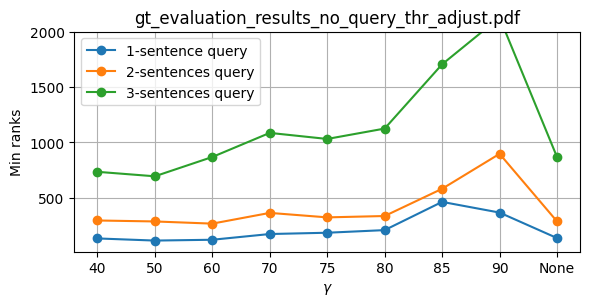

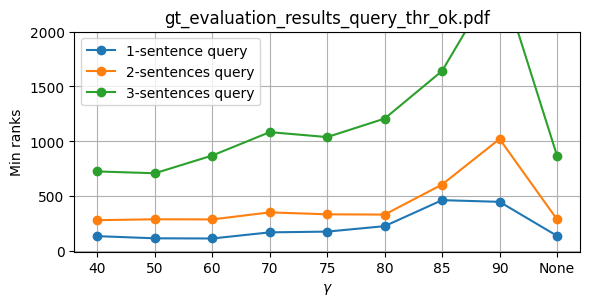

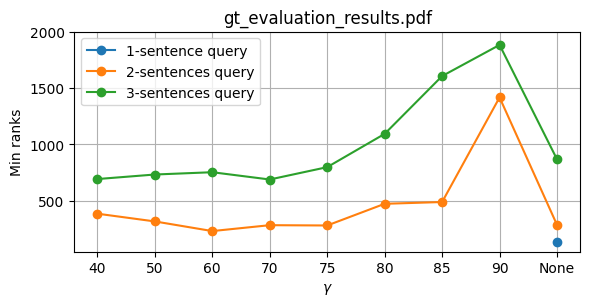

In [14]:
eval_1 = 'alad/extraction/v3c_gt_evaluation/results/gt_evaluation_results_no_query_thr_adjust.json'
eval_2 = 'alad/extraction/v3c_gt_evaluation/results/gt_evaluation_results_query_thr_ok.json'
eval_3 = 'alad/extraction/v3c_gt_evaluation/results/gt_evaluation_results.json'

plot_ranks_vs_threshold(eval_1)
plot_ranks_vs_threshold(eval_2)
plot_ranks_vs_threshold(eval_3)

                   mode sq_thr    nz_elems  query_0  query_1  query_2  \
0  2-queries-merged-min     50  465.943922       69       49        2   
1  2-queries-merged-min     60  399.792310       73       51        1   
2  2-queries-merged-min     70  329.402194      149       92        4   
3  2-queries-merged-min     75  291.823646       78       74        3   
4  2-queries-merged-min     80  251.963043       42       55        3   
5  2-queries-merged-min     85  209.182179       20       53        1   
6  2-queries-merged-min     90  161.600278       23       44        0   
7  2-queries-merged-min   None         NaN       33       32        1   

   query_3  query_4  query_5  query_6  query_7  
0     1728       22       25      551      260  
1      962        8       41      509      203  
2      932       27       33      307      209  
3     1923       26        9      226      194  
4     2907       18       57      497      303  
5      743       65      152      426      454  

<AxesSubplot:xlabel='sq_thr'>

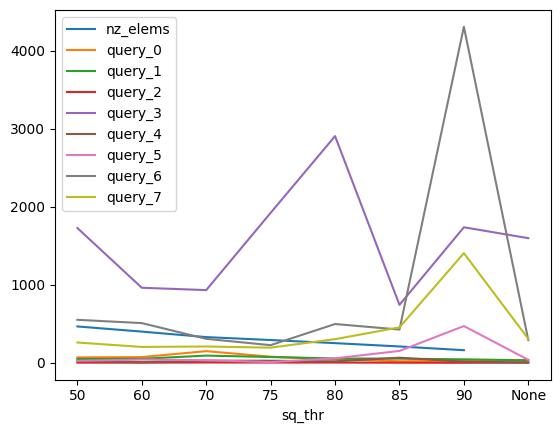

In [7]:
df = pd.DataFrame(gt_experiments)
for i in range(8):
    df['query_'+str(i)] = df['ranks'].map(lambda rank: rank[i])
del df['ranks']
df = df.loc[df['mode'] == '2-queries-merged-min']
df = pd.concat([df[df['sq_thr'] != 'None'], df[df['sq_thr'] == 'None']], ignore_index=True)
print(df)
df.plot(x="sq_thr")

             ranks                                          
mode   1-query-min 2-queries-merged-min 3-queries-merged-min
sq_thr                                                      
20         505.625              364.000              739.250
26         314.625              198.500              708.875
40         466.750              309.000              772.750
None       699.250              337.625             1151.000


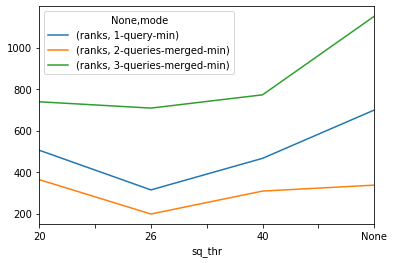

                   mode sq_thr  query_0  query_1  query_2  query_3  query_4  \
0  2-queries-merged-min     18      341      407        2     3446        9   
1  2-queries-merged-min     22      164      179        2     6494        2   
2  2-queries-merged-min     26       56      267        2     1687        6   
3  2-queries-merged-min     30       62      301        2     1215        5   
4  2-queries-merged-min     40       50      185        3     1007        6   
5  2-queries-merged-min     50       31      127        3     1369        4   
6  2-queries-merged-min   None       33       32        1     1598        5   

   query_5  query_6  query_7  
0      234       68      895  
1       14       51      708  
2       20       30      652  
3       39       50      906  
4       29       48      344  
5       12       42      455  
6       38      291      307  


<AxesSubplot:xlabel='sq_thr'>

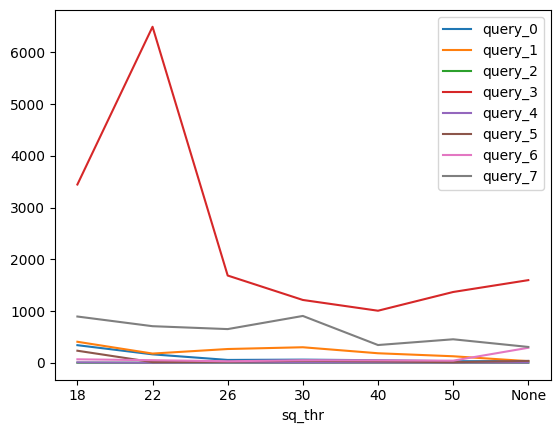

In [9]:
df = pd.DataFrame(gt_experiments)
for i in range(8):
    df['query_'+str(i)] = df['ranks'].map(lambda rank: rank[i])
del df['ranks']
df = df.loc[df['mode'] == '2-queries-merged-min']
df = pd.concat([df[df['sq_thr'] != 'None'], df[df['sq_thr'] == 'None']], ignore_index=True)
print(df)
df.plot(x="sq_thr")